In [3]:
import pandas as pd
pd.set_option('display.max_rows', 500)
import numpy as np

import re
import time
import math
import sys

from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample

from scipy.spatial import ConvexHull

import matplotlib.pyplot as plt

from shapely.geometry import Point, Polygon

In [4]:
datasets = [
    '../etc/data/auto2.csv',
    '../etc/data/auto93.csv',
    '../etc/data/china.csv',
    '../etc/data/coc1000.csv',
    '../etc/data/coc10000.csv',
    '../etc/data/health-easy.csv',
    '../etc/data/health-hard.csv',
    '../etc/data/nasa93dem.csv',
    '../etc/data/pom.csv',
    '../etc/data/SSM.csv',
    '../etc/data/SSN.csv'
]

In [13]:
df = pd.read_csv(datasets[1])

In [14]:
df.head()

,Clndrs,Volume,HpX,Lbs-,Acc+,Model,origin,Mpg+
0,8,304.0,193,4732,18.5,70,1,10
1,8,360.0,215,4615,14.0,70,1,10
2,8,307.0,200,4376,15.0,70,1,10
3,8,318.0,210,4382,13.5,70,1,10
4,8,429.0,208,4633,11.0,72,1,10


In [15]:
xcols = []
numxcols = []
catxcols = []
ycols = []
wcols = []

for col in df.columns:
    if len(re.findall(r'[!+-]$', col.strip())) > 0:
        if len(re.findall(r'[+]$', col.strip())) > 0:
            wcols.append(1)
        elif len(re.findall(r'[-]$', col.strip())) > 0:
            wcols.append(-1)
        ycols.append(col)
    elif len(re.findall(r'X$', col.strip())) == 0:
        if len(re.findall(r'^[A-Z]+', col.strip())) > 0:
            numxcols.append(col)
        else:
            catxcols.append(col)
        
        xcols.append(col)

In [16]:
newdf = df.copy()

for x in xcols:
    newdf = newdf.drop(list(df[df[x] == '?'].index), axis=0, errors='ignore')
    
    if x in catxcols:
        newdf[x] = LabelEncoder().fit_transform(newdf[x])
    else:
        newdf[x] = newdf[x].astype(float)

newdf.reset_index(drop=True, inplace=True)

In [17]:
X = Normalizer().fit_transform(newdf[xcols].values)
Y = Normalizer().fit_transform(newdf[ycols].values)

pca = PCA(n_components=2)
newX = pca.fit_transform(X)

In [18]:
print(newX.shape)

(398, 2)


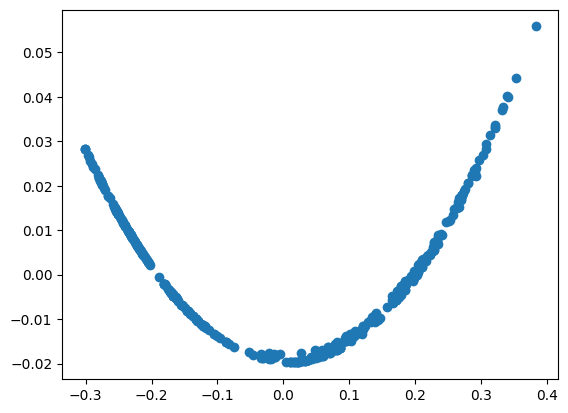

In [19]:
plt.scatter(newX[:, 0], newX[:, 1])

In [20]:
hull = ConvexHull(newX)

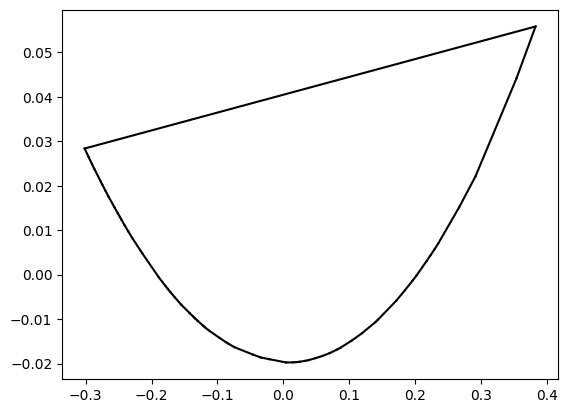

In [21]:
for simplex in hull.simplices:
    plt.plot(newX[simplex, 0], newX[simplex, 1], 'k-')

In [22]:
len(newX[hull.vertices])

print(newX[hull.vertices].shape)

# Number of vertices for all datasets: 10, 66, 20, 15, 11, 35, 35, 8, 23, 105, 39

(66, 2)


In [25]:
minX, maxX, minY, maxY = min(newX[hull.vertices][:, 0]), max(newX[hull.vertices][:, 0]), min(newX[hull.vertices][:, 1]), max(newX[hull.vertices][:, 1])
center = (abs(maxX)-abs(minX))/2, (abs(maxY)-abs(minY))/2

# print(minX, maxX, minY, maxY)
# print(center)

quads = {'tl': [], 'tr': [], 'br': [], 'bl': []}
for v in newX[hull.vertices]:
    if v[0] <= center[0] and v[1] <= center[1]:
        quads['bl'].append(v)
    elif v[0] < center[0] and v[1] > center[1]:
        quads['tl'].append(v)
    elif v[0] > center[0] and v[1] > center[1]:
        quads['tr'].append(v)
    elif v[0] > center[0] and v[1] < center[1]:
        quads['br'].append(v)

# Picking equal number of points from each quadrant
numberOfSamples = int(len(hull.vertices)/4) * 2

# Sampling equal samples from each of the four quadrants
sampleVertices = {'tl': [], 'tr': [], 'br': [], 'bl': []}
for k, quad in quads.items():
    if len(quad) <= numberOfSamples:
        # Sample with replacement
        sampleVertices[k].append(np.squeeze(resample(quad, n_samples=numberOfSamples, replace=True)))
    else:
        # Sample without replacement
        sampleVertices[k].append(np.squeeze(resample(quad, n_samples=numberOfSamples, replace=False)))
        
# Form quandrangles from the sample vertices (pick one from each quadrant)
sampleQuadrangles = []
for i in range(numberOfSamples):
    sampleQuadrangle = {}
    for k, quad in sampleVertices.items():
        sampleQuadrangle[k] = quad[0][i]
    sampleQuadrangles.append(sampleQuadrangle)
    
    
def findIntersection(p1, p2, p3, p4):
    x = (((p1[0]*p2[1]-p1[1]*p2[0])*(p3[0]-p4[0])) - ((p1[0]-p2[0])*(p3[0]*p4[1]-p3[1]*p4[0])))/((p1[0]-p2[0])*(p3[1]-p4[1])-(p1[1]-p2[1])*(p3[0]-p4[0]))
    y = (((p1[0]*p2[1]-p1[1]*p2[0])*(p3[1]-p4[1])) - ((p1[1]-p2[1])*(p3[0]*p4[1]-p3[1]*p4[0])))/((p1[0]-p2[0])*(p3[1]-p4[1])-(p1[1]-p2[1])*(p3[0]-p4[0]))
    return np.array([x, y])

def area(vertices):
    _sum = 0
    for i in range(len(vertices)):
        _sum += vertices[i][0]*vertices[(i+1)%len(vertices)][1] - vertices[i][1]*vertices[(i+1)%len(vertices)][0]
    return _sum/2

def findInclusive(sampleQuadrangle, points):
    sampleQuadrangle['inclusive'] = []
    for idx, point in enumerate(points):
        _area = area([sampleQuadrangle['bl'], sampleQuadrangle['br'], point]) + area([sampleQuadrangle['br'], sampleQuadrangle['tr'], point]) + area([sampleQuadrangle['tr'], sampleQuadrangle['tl'], point]) + area([sampleQuadrangle['tl'], sampleQuadrangle['bl'], point])
        
        if _area > sampleQuadrangle['area']:
            sampleQuadrangle['inclusive'].append(idx)
    
# Find the centroid of each of the quadrilaterals (using four triangles)
for sampleQuadrangle in sampleQuadrangles:
    t1centroid = (sampleQuadrangle['bl'][0] + sampleQuadrangle['tl'][0] + sampleQuadrangle['tr'][0])/3, (sampleQuadrangle['bl'][1] + sampleQuadrangle['tl'][1] + sampleQuadrangle['tr'][1])/3
    t2centroid = (sampleQuadrangle['tr'][0] + sampleQuadrangle['br'][0] + sampleQuadrangle['bl'][0])/3, (sampleQuadrangle['tr'][1] + sampleQuadrangle['br'][1] + sampleQuadrangle['bl'][1])/3
    t3centroid = (sampleQuadrangle['tl'][0] + sampleQuadrangle['tr'][0] + sampleQuadrangle['br'][0])/3, (sampleQuadrangle['tl'][1] + sampleQuadrangle['tr'][1] + sampleQuadrangle['br'][1])/3
    t4centroid = (sampleQuadrangle['br'][0] + sampleQuadrangle['bl'][0] + sampleQuadrangle['tl'][0])/3, (sampleQuadrangle['br'][1] + sampleQuadrangle['bl'][1] + sampleQuadrangle['tl'][1])/3
    
    # Finding quadtrilateral centroid using 4 triangle centroids
    sampleQuadrangle['center'] = findIntersection(t1centroid, t2centroid, t3centroid, t4centroid)
    
    # Finding quadrilateral area using 4 triangle area
    sampleQuadrangle['area'] = area([sampleQuadrangle['bl'], sampleQuadrangle['br'], sampleQuadrangle['tr'], sampleQuadrangle['tl']])
    
    # Finding 4 lines that go through the centroid of a particular quadrilateral
    # The first point of each of 4 lines are the center of each side of the quadrilateral
    mid1 = [np.array([(sampleQuadrangle['bl'][0]+sampleQuadrangle['tl'][0])/2, (sampleQuadrangle['bl'][1]+sampleQuadrangle['tl'][1])/2])]
    mid2 = [np.array([(sampleQuadrangle['tr'][0]+sampleQuadrangle['br'][0])/2, (sampleQuadrangle['tr'][1]+sampleQuadrangle['br'][1])/2])]
    mid3 = [np.array([(sampleQuadrangle['tl'][0]+sampleQuadrangle['tr'][0])/2, (sampleQuadrangle['tl'][1]+sampleQuadrangle['tr'][1])/2])]
    mid4 = [np.array([(sampleQuadrangle['br'][0]+sampleQuadrangle['bl'][0])/2, (sampleQuadrangle['br'][1]+sampleQuadrangle['bl'][1])/2])]
    
    # The second point of each of 4 lines w.r.t each side's center is the intersection of lineM (side's center, centroid) and lineN (opposite side)
    mid1.append(findIntersection(mid1[0], sampleQuadrangle['center'], sampleQuadrangle['br'], sampleQuadrangle['tr']))
    mid2.append(findIntersection(mid2[0], sampleQuadrangle['center'], sampleQuadrangle['bl'], sampleQuadrangle['tl']))
    mid3.append(findIntersection(mid3[0], sampleQuadrangle['center'], sampleQuadrangle['bl'], sampleQuadrangle['br']))
    mid4.append(findIntersection(mid4[0], sampleQuadrangle['center'], sampleQuadrangle['tl'], sampleQuadrangle['tr']))
    
    sampleQuadrangle['mid1'] = mid1
    sampleQuadrangle['mid2'] = mid2
    sampleQuadrangle['mid3'] = mid3
    sampleQuadrangle['mid4'] = mid4
    
    # Finding the points that are located within a particular quadrilateral
    findInclusive(sampleQuadrangle, newX)
    
    # sampleQuadrangle['inclusive'] = range(len(newX))

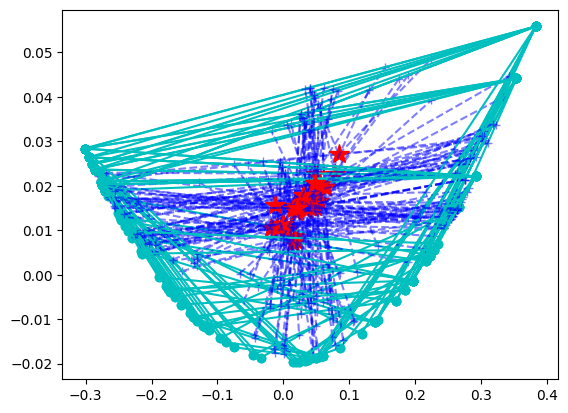

In [26]:
def plotQuadrangle(quad):
    plotLine(quad['tl'], quad['tr'])
    plotLine(quad['tr'], quad['br'])
    plotLine(quad['br'], quad['bl'])
    plotLine(quad['bl'], quad['tl'])
    
    plotLine(quad['mid1'][0], quad['mid1'][1], alpha=0.5, marker='+', color='b', linestyle='--')
    plotLine(quad['mid2'][0], quad['mid2'][1], alpha=0.5, marker='+', color='b', linestyle='--')
    plotLine(quad['mid3'][0], quad['mid3'][1], alpha=0.5, marker='+', color='b', linestyle='--')
    plotLine(quad['mid4'][0], quad['mid4'][1], alpha=0.5, marker='+', color='b', linestyle='--')
    
    plotCentroid(sampleQuadrangles[i]['center'])

def plotLine(p1, p2, alpha=1, marker='o', color='c', linestyle='-'):
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], alpha=alpha, marker=marker, color=color, linestyle=linestyle)
    
def plotCentroid(p):
    plt.plot(p[0], p[1], marker='*', markersize=15, color='r')

for i in range(0, numberOfSamples):
    plotQuadrangle(sampleQuadrangles[i])

In [ ]:
def project(p1, p2, p3):          
    a = math.dist(p1, p3)
    b = math.dist(p2, p3)
    c = math.dist(p1, p2)
    
    x1 = (a**2 + c**2 - b**2)/(2*c+1e-32)
    x2 = max(0, min(1, x1))
    y = abs(a**2 - x2**2)**0.5
    
    return x2, y

def better(y1, y2):
        s1, s2 = 0, 0
        x, y = 0, 0
        for i in range(len(ycols)):
            x = y1[i]
            y = y2[i]
            
            s1 = s1 - math.exp(wcols[i] * (x-y)/len(ycols))
            s2 = s2 - math.exp(wcols[i] * (y-x)/len(ycols))
            
        return s1/len(ycols) < s2/len(ycols)
    
def betters(sample1, sample2):
    y1counter, y2counter = 0, 0
    
    y1s = [Y[entry[0]] for entry in sample1]
    y2s = [Y[entry[0]] for entry in sample2]
    
    for m in range(len(y1s)):
        for n in range(len(y2s)):
            if better(y1s[m], y2s[n]):
                y1counter += 1
            else:
                y2counter += 1
                
    if y1counter >= y2counter:
        return sample1
    else:
        return sample2

In [ ]:
print(ycols)
print(wcols)

In [ ]:
for sampleQuadrangle in sampleQuadrangles:
    sampleQuadrangle['projection1'], sampleQuadrangle['projection2'], sampleQuadrangle['projection3'], sampleQuadrangle['projection4'] = [], [], [], []
    
    for idx in sampleQuadrangle['inclusive']:
        # sampleQuadrangle['projection1'].append([idx, project(sampleQuadrangle['mid1'][0], sampleQuadrangle['mid1'][1], newX[idx])])
        # sampleQuadrangle['projection2'].append([idx, project(sampleQuadrangle['mid2'][0], sampleQuadrangle['mid2'][1], newX[idx])])
        # sampleQuadrangle['projection3'].append([idx, project(sampleQuadrangle['mid3'][0], sampleQuadrangle['mid3'][1], newX[idx])])
        # sampleQuadrangle['projection4'].append([idx, project(sampleQuadrangle['mid4'][0], sampleQuadrangle['mid4'][1], newX[idx])])
        
        sampleQuadrangle['projection1'].append([idx, project(sampleQuadrangle['mid1'][0], sampleQuadrangle['center'], newX[idx])])
        sampleQuadrangle['projection2'].append([idx, project(sampleQuadrangle['mid2'][0], sampleQuadrangle['center'], newX[idx])])
        sampleQuadrangle['projection3'].append([idx, project(sampleQuadrangle['mid3'][0], sampleQuadrangle['center'], newX[idx])])
        sampleQuadrangle['projection4'].append([idx, project(sampleQuadrangle['mid4'][0], sampleQuadrangle['center'], newX[idx])])
        
    sampleQuadrangle['projection1'] = sorted(sampleQuadrangle['projection1'], key=lambda val: val[1])
    sampleQuadrangle['projection2'] = sorted(sampleQuadrangle['projection2'], key=lambda val: val[1])
    sampleQuadrangle['projection3'] = sorted(sampleQuadrangle['projection3'], key=lambda val: val[1])
    sampleQuadrangle['projection4'] = sorted(sampleQuadrangle['projection4'], key=lambda val: val[1])

In [ ]:
# for sampleQuadrangle in sampleQuadrangles:    
#     if len(sampleQuadrangle['projection1']) > 0:
#         sampleQuadrangle['projection1'] = betters(sampleQuadrangle['projection1'][:int(len(sampleQuadrangle['projection1'])/2)], sampleQuadrangle['projection1'][int(len(sampleQuadrangle['projection1'])/2):])
#     #-------------------------------------------------------------------------------------------------------------------------------------
#     if len(sampleQuadrangle['projection2']) > 0:
#         sampleQuadrangle['projection2'] = betters(sampleQuadrangle['projection2'][:int(len(sampleQuadrangle['projection2'])/2)], sampleQuadrangle['projection2'][int(len(sampleQuadrangle['projection2'])/2):])
#     #-------------------------------------------------------------------------------------------------------------------------------------
#     if len(sampleQuadrangle['projection3']) > 0:
#         sampleQuadrangle['projection3'] = betters(sampleQuadrangle['projection3'][:int(len(sampleQuadrangle['projection3'])/2)], sampleQuadrangle['projection3'][int(len(sampleQuadrangle['projection3'])/2):])
#     #-------------------------------------------------------------------------------------------------------------------------------------
#     if len(sampleQuadrangle['projection4']) > 0:
#         sampleQuadrangle['projection4'] = betters(sampleQuadrangle['projection4'][:int(len(sampleQuadrangle['projection4'])/2)], sampleQuadrangle['projection4'][int(len(sampleQuadrangle['projection4'])/2):])

In [ ]:
idealQuadrangle = sampleQuadrangle['projection1']

for sampleQuadrangle in sampleQuadrangles:
    if len(sampleQuadrangle['projection1']) > 0 and betters(sampleQuadrangle['projection1'], idealQuadrangle):
        idealQuadrangle = sampleQuadrangle['projection1']
    if len(sampleQuadrangle['projection2']) > 0 and betters(sampleQuadrangle['projection2'], idealQuadrangle):
        idealQuadrangle = sampleQuadrangle['projection2']
    if len(sampleQuadrangle['projection3']) > 0 and betters(sampleQuadrangle['projection3'], idealQuadrangle):
        idealQuadrangle = sampleQuadrangle['projection3']
    if len(sampleQuadrangle['projection4']) > 0 and betters(sampleQuadrangle['projection4'], idealQuadrangle):
        idealQuadrangle = sampleQuadrangle['projection4']

In [ ]:
# idxCounter = {}
# for sampleQuadrangle in sampleQuadrangles:
#     for entry in sampleQuadrangle['projection1']:
#         if entry[0] not in idxCounter:
#             idxCounter[entry[0]] = 1
#         else:
#             idxCounter[entry[0]] += 1
            
#     for entry in sampleQuadrangle['projection2']:
#         if entry[0] not in idxCounter:
#             idxCounter[entry[0]] = 1
#         else:
#             idxCounter[entry[0]] += 1
            
#     for entry in sampleQuadrangle['projection3']:
#         if entry[0] not in idxCounter:
#             idxCounter[entry[0]] = 1
#         else:
#             idxCounter[entry[0]] += 1
            
#     for entry in sampleQuadrangle['projection4']:
#         if entry[0] not in idxCounter:
#             idxCounter[entry[0]] = 1
#         else:
#             idxCounter[entry[0]] += 1
            
# sortedIdxCounter = sorted(idxCounter.items(), reverse=True, key=lambda x: x[1])

In [ ]:
reference = []
for i, ycol in enumerate(ycols):
    if wcols[i] > 0: reference.append(max(Y[i]))
    else: reference.append(min(Y[i]))

err = float('inf')
chosen = None
for width in [5, 10, 20]:
    for k in range(len(idealQuadrangle)-width):
        ys = np.mean(Y[[entry[0] for entry in idealQuadrangle[k:k+width]]], axis=0)
        
        temp = np.sqrt(np.sum(ys-reference)**2)
        if temp < err:
            err = temp
            chosen = idealQuadrangle[k:k+width]

temp = []
for entry in chosen:
    temp.append(newdf[ycols].iloc[entry[0]].values)
    
print(ycols)
print(wcols)
print(np.mean(temp, axis=0))
print(len(chosen))
        
# print(newdf[ycols].iloc[[entry[0] for entry in sortedIdxCounter[0:30]]].mean(axis=0))
# print(newdf[ycols].iloc[[entry[0] for entry in idealQuadrangle[35:40]]].mean(axis=0))
# print('-------------------------')

# for entry in idealQuadrangle:
#     print(newdf[ycols].iloc[entry[0]])
#     print()

# for sampleQuadrangle in sampleQuadrangles:
#     print(newdf[ycols].iloc[[entry[0] for entry in sampleQuadrangle['projection1']]].mean(axis=0))
#     print('-------------------------')
#     print(newdf[ycols].iloc[[entry[0] for entry in sampleQuadrangle['projection2']]].mean(axis=0))
#     print('-------------------------')
#     print(newdf[ycols].iloc[[entry[0] for entry in sampleQuadrangle['projection3']]].mean(axis=0))
#     print('-------------------------')
#     print(newdf[ycols].iloc[[entry[0] for entry in sampleQuadrangle['projection4']]].mean(axis=0))
#     print('-------------------------')